In [506]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Faulty Machine?

Binary Classification Task: Build a classification model to classify Failed Machines and Normal Machines

Importing dataset from google drive into google colab

In [507]:
# # Let google colab access google drive
# from google.colab import drive
# drive.mount('/content/drive')

# # read factory data into dataframe from google drive
# factory_df = pd.read_csv('/content/drive/MyDrive/Singapore Poly/Year 2/AIML/AIML-ST1511-CA1/factory_data (classification).csv')

Importing dataset into jupyter notebook

In [508]:
#read factory data into dataframe
factory_df = pd.read_csv("factory_data (classification).csv")

In [509]:
# check dataset is loaded properly
factory_df.head()

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0


# Feature Engineering
Initial feature engineering before Exploratory Data Analysis

## 1) Drop ID Columns
Unique ID and Product ID columns are dropped as they are not useful for training the model

In [510]:
factory_df = factory_df.drop(['Unique ID', 'Product ID'], axis=1)

## 2) New feature `Horsepower`
Formula:

* Horsepower = Torque x RPM / 5252 (where 5252 is a constant)


Definition:

* The rate at which work is done
* Usually used for motors and engines to gauge how much power an engine can produce in a certain amount of time

In [511]:
factory_df['horsepower'] = factory_df['Torque (Nm)'] * factory_df['Rotation Speed (rpm)'] / 5252

## 3) New feature `temp_diff`
Calculation:
* Temperature Difference = Process Temperature - Ambient Temperature

What it represents:
* The difference between the temperature of the machine and its surrounding.
* The higher the number, the higher the machine's temperature is compared to surrounding temperature

In [512]:
factory_df['temp_diff'] = factory_df['Process T (C)'] - factory_df['Ambient T (C)']

# Exploratory Data Analysis
Finding out more about the dataset

## Descriptive Summaries
* 20000 rows and 9 columns in this dataset. (7 continuous features, 1 categorical feature excluding target feature)
* Missing values for 5 columns: Quality, Process T (C), Rotation Speed (rpm), horsepower, temp_diff (Missing values in horsepower, temp_diff due to missing values in the features used to calculate the 2 new features)
* 3 unique values for 'Quality': L, M, H (Low, Medium, High)
* 2 unique values for target variable 'Machine Status': 0 (Normal), 1 (Failure), confirms that this is a binary classification task
* The numerical features have a large difference in magnitude, and standard deviation. This may pose as a problem when using distanced based models such as K-nearest Neighbors

In [513]:
print(factory_df.info()) # descriptive summary of the data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Quality               19009 non-null  object 
 1   Ambient T (C)         20000 non-null  float64
 2   Process T (C)         19600 non-null  float64
 3   Rotation Speed (rpm)  18812 non-null  float64
 4   Torque (Nm)           20000 non-null  float64
 5   Tool Wear (min)       20000 non-null  int64  
 6   Machine Status        20000 non-null  int64  
 7   horsepower            18812 non-null  float64
 8   temp_diff             19600 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.4+ MB
None


In [514]:
print(f"\nUnique Values in Quality column: {factory_df['Quality'].nunique()}")
print(f"{factory_df['Quality'].unique()}")


Unique Values in Quality column: 3
['M' 'L' nan 'H']


In [515]:
print(f"\nMissing Values: \n{factory_df.isna().sum()}")


Missing Values: 
Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
Machine Status             0
horsepower              1188
temp_diff                400
dtype: int64


In [516]:
desc_df = factory_df.drop(['Machine Status'], axis=1)
desc_df.describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower,temp_diff
count,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000,18812.000000,19600.000000
mean,26.904930,36.904291,1538.795397,39.986910,107.951000,11.421115,10.002974
std,2.000834,1.483647,178.674963,9.968684,63.652555,1.943179,1.000848
min,22.150000,32.550000,1168.000000,3.800000,0.000000,2.088119,7.600000
25%,25.250000,35.750000,1423.000000,33.200000,53.000000,10.105079,9.300000
50%,26.950000,36.950000,1503.000000,40.100000,108.000000,11.400581,9.800000
75%,28.450000,37.950000,1613.000000,46.800000,162.000000,12.742403,11.000000
max,31.450000,40.750000,2886.000000,76.600000,253.000000,19.036634,12.100000


## Countplots
* From the 1st chart, it can be infered that this is an imbalanced dataset as the target variable is not balanced as it has a huge uneven distribution of observations between failure and normal machines. This is a potential issue as an imbalanced dataset is prone to overfitting of the model
* On the 2nd chart, We can see that there is a trend between quality of machine and machine status, as count of machine failure goes up as quality of machine decreses (High, Medium, Low)

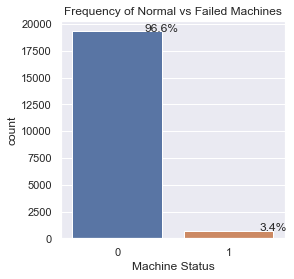

In [517]:
total = float(len(factory_df))

#countplot to compare the count of both machine status in the dataset
ax = sns.countplot(x='Machine Status', data=factory_df)
plt.title('Frequency of Normal vs Failed Machines')

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

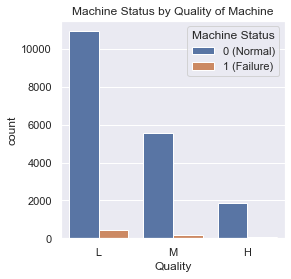

In [518]:
#countplot to compare quality by machine status in the dataset
sns.countplot(x='Quality', hue='Machine Status', data=factory_df, order=["L", "M", "H"])
plt.title('Machine Status by Quality of Machine')
plt.legend(title='Machine Status', loc='upper right', labels=['0 (Normal)', '1 (Failure)'])

plt.show()

## Heatmap
The (Pearson) correlation heatmap several features that are highly correlated with one another, such as Ambient Temperature and Process Temperature, Torque and Rotational Speed.

The occurrence of the multicollinearity issue in a classification model can affect the interpretability of the model

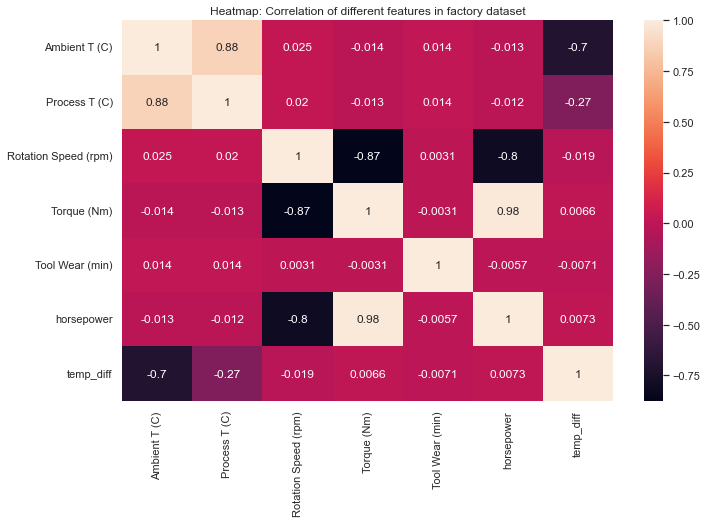

In [519]:
sns.set(rc={'figure.figsize':(11,7)})
corr_df = factory_df.drop(['Machine Status'], axis=1)

correlation = corr_df.corr()
sns.heatmap(correlation, cmap='rocket', annot=True)

plt.title("Heatmap: Correlation of different features in factory dataset")
plt.show()

## Boxplot

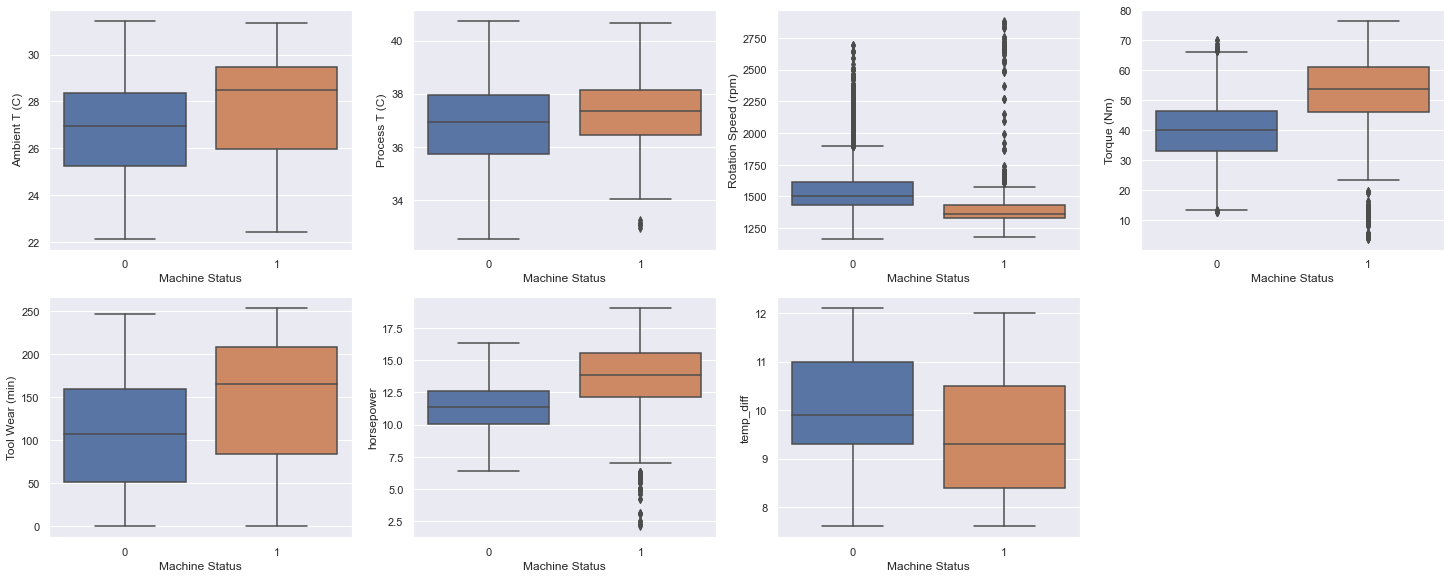

In [520]:
feature_list = ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'horsepower', 'temp_diff']
factory_df2 = factory_df.astype({'Machine Status': 'object'}, copy=False)

fig = plt.figure(figsize = (25, 15))
i = 0

for feature in feature_list:
  sub = fig.add_subplot(3, 4, i + 1)
  sns.boxplot(x='Machine Status', y=feature, data=factory_df2)
  i += 1

plt.show()

## Pairplot
* The pairplot shows that majority of Machine Failure happens when Torque, Rotation Speed or Horsepower is above or below the average.
* Machine Failure can happen across any temperature

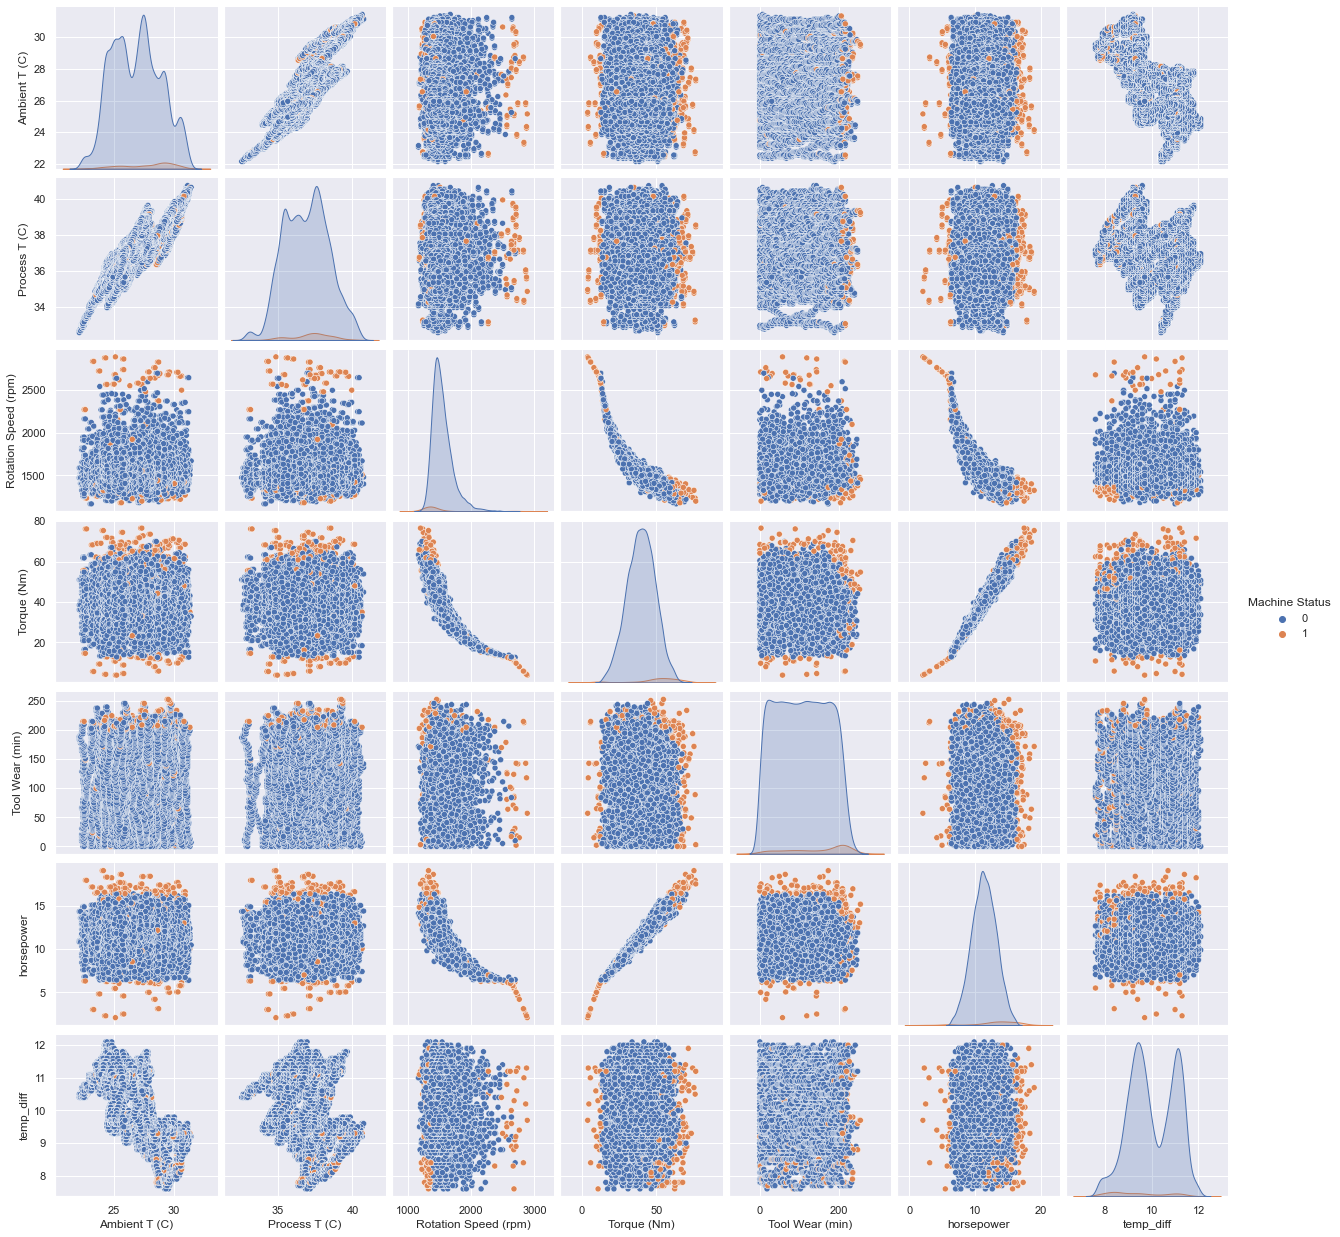

In [521]:
sns.pairplot(factory_df, hue="Machine Status")

plt.show()

# Data Preprocessing
Preparing the data to train the model

In [522]:
#pip install -U imbalanced-learn

In [523]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1) Ordinal Encoding
The `Quality` feature needs to encoded 

For this feature ordinal encoding is possible as the 'Quality' feature consists of 'Low', 'Medium', 'High' values, which can be ranked as 0, 1, 2.


In [524]:
quality = ['L', 'M', 'H'] #rank the different qualities in a array for OrdinalEncoder

ordi = OrdinalEncoder(categories=[quality]) #instantiate OrdinalEncoder

In [525]:
# Filter out rows where Quality is NaN as OrdinalEncoder cannot deal with missing values

factory_df_isna = factory_df[factory_df['Quality'].isna()] # extract all the rows with missing values in 'Quality' column
factory_df_isna = factory_df_isna.reset_index(drop=True) # reset index

factory_df_notna = factory_df[factory_df['Quality'].notna()] # drop rows with missing values in 'Quality' column
factory_df_notna = factory_df_notna.reset_index(drop=True) # reset index

In [526]:
new_quality_col = pd.DataFrame(ordi.fit_transform(factory_df_notna[['Quality']]), columns=['quality']) # Ordinal Encode Quality feature

In [527]:
factory_df_notna = pd.concat([factory_df_notna, new_quality_col], axis=1) # Concatenate the encoded 'Quality' feature to factory_df_notna

In [528]:
factory_df = pd.concat([factory_df_notna, factory_df_isna], axis=0) # combine seperated dataframes back into factory_df
factory_df = factory_df.reset_index(drop=True)

factory_df = factory_df.drop(['Quality'], axis=1) # Drop Quality feature as it is not needed anymore

In [529]:
factory_df.head() # new quality column

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status,horsepower,temp_diff,quality
0,24.95,35.45,1551.0,42.8,0,0,12.639528,10.5,1.0
1,25.05,35.55,1408.0,46.3,3,0,12.412490,10.5,0.0
2,24.95,35.35,1498.0,49.4,5,0,14.090099,10.4,0.0
3,25.05,35.45,1433.0,39.5,7,0,10.777513,10.4,0.0
4,25.05,35.55,1408.0,40.0,9,0,10.723534,10.5,0.0


In [530]:
print(f"Unique values in quality feature: {list(factory_df['quality'].unique())}")

Unique values in quality feature: [1.0, 0.0, 2.0, nan]


## 2) Train Test Split
As the target label is unbalanced, stratify can be used to preserve the percentage of samples for both classes of the target label (Failed Machine and Normal Machine)

Splitting is done before further preprocessing the data to ensure that all the decisions made are purely based on the training data. (Minimize data leakage)

In [531]:
X = factory_df.drop(['Machine Status'], axis = 1)
y = factory_df['Machine Status']

In [532]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify so that percentage of samples are presered

# reset index for x_train and x_test
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# reset index for y_train and y_test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [533]:
print(f"Percentage of label '0' in Training data: {(len(y_train[y_train == 0]) / len(y_train)) * 100}%")
print(f"Percentage of label '0' in Test data: {(len(y_test[y_test == 0]) / len(y_test)) * 100}%")

Percentage of label '0' in Training data: 96.6125%
Percentage of label '0' in Test data: 96.6%


## 3) Feature Scaling
Feature Scaling is done as some classification models use distance-based algorithms. Since numerical features are of different magnitudes, standardization is done to convert all features to have a mean of 0 and standard deviation of 1. It is also a good idea to scale as values will converge faster

For feature scaling, there are 2 techniques that can be used to scale the data.
1. Normalization, also known as min-max scaling, bounds all data points in the dataset between 0 and 1. The good thing about this formula is that it guarantees all features will have the exact same scale after the process but it does not handle outliers well due to the formula making the largest data point 1.
2. Standardization,
also known as z-score normalization. The mean will be normalized to 0 like in a z-score distribution. This formula preserves the outliers better as compared to min-max scaling but it does not replicate the exact same scale between data points

Since the outliers are important for prediction in this dataset, standardization (StandardScaler) would be used to scale the data

In [534]:
scaler = StandardScaler() # StandardScaler object

col_names = ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'horsepower', 'temp_diff'] # columns to standardize

scaler.fit(X_train[col_names]) # fit StandardScaler object on X_train

StandardScaler()

In [535]:
# Standardize X_train and X_test values
scaled_X_train = pd.DataFrame(scaler.transform(X_train[col_names]), columns = col_names)
scaled_X_test = pd.DataFrame(scaler.transform(X_test[col_names]), columns = col_names)

# Drop original values from X_train and X_test
X_train = X_train.drop(columns=col_names)
X_test = X_test.drop(columns=col_names)

# Concatenate new standardized values to X_train and X_test
X_train = pd.concat([X_train, scaled_X_train], axis=1)
X_test = pd.concat([X_test, scaled_X_test], axis=1)

In [536]:
X_train.head() # X_train after standardization

,quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower,temp_diff
0,0.0,0.772370,0.301032,-0.633142,1.438379,-1.584608,1.710378,-1.098051
1,0.0,0.472075,1.113269,NaN,-0.869245,0.660617,NaN,0.695742
2,0.0,0.221830,1.180955,-0.527178,1.118708,1.037438,1.360331,1.293673
3,0.0,-0.228612,-0.849637,NaN,-2.697362,1.115943,NaN,-0.799085
4,1.0,1.523106,0.639464,-0.159093,0.759078,-1.443300,1.159624,-2.094602


In [537]:
X_test.head() # X_test after standardization

,quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower,temp_diff
0,2.0,1.322910,0.977896,0.097451,-0.499625,0.880430,-0.539868,-1.197706
1,1.0,0.021634,-0.781951,0.052835,-0.159975,-1.207787,-0.053596,-1.197706
2,1.0,-1.279642,-1.188069,-0.014089,-0.539584,-1.631711,-0.668130,0.795397
3,2.0,-0.478857,0.368718,1.408057,-1.198905,0.943233,-0.960642,1.492983
4,0.0,0.021634,-0.511205,0.644002,-0.899214,1.461362,-0.850765,-0.799085


## 4) Data Imputation
As there are 3 columns with missing values in the dataset, figuring out a strategy to impute the missing data is required.

Columns with missing values:
1. Process T (C)
2. Rotation Speed (rpm)
3. quality

These are the possible ways to fill the missing values
1. Measure of Central Tendency (Mean, Median, Mode)
2. Use sk-learn's KNNImputer

* KNNImputer is most favourable as it is a multivariate imputation, taking into consideration other features when imputing the values.

* Dropping rows with missing values is not favourable as we will lose many other data points in the process of doing so.*
* KNNImputer will be used for all missing values as all of the missing values in this dataset are continuous except for Quality feature
* For Quality feature, np.round will be used to round off to nearest integer after using KNNImputer. This can be justified as KNNImputer uses euclidean distance to impute missing values, thus the missing values in Quality feature can better imputed using KNN than just using Most Frequent
* Since the dataset has already been standardized, KNNImputer can be used immediately (It uses euclidean distance-based algorithm so standardization is necessary so that values converge faster and also to reduce potential biasness)

(Imputation is based on training dataset only)

In [538]:
imp_knn = KNNImputer() # KNNImputer object

imp_knn.fit(X_train) # fit KNNImputer object on X_train

KNNImputer()

In [539]:
X_train = pd.DataFrame(imp_knn.transform(X_train), columns=X_train.columns) # impute X_train data
X_test = pd.DataFrame(imp_knn.transform(X_test), columns=X_test.columns) # impute X_test data

In [540]:
X_train.isna().sum() # missing values in X_train

quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
horsepower              0
temp_diff               0
dtype: int64

In [541]:
X_test.isna().sum() # missing values in X_test

quality                 0
Ambient T (C)           0
Process T (C)           0
Rotation Speed (rpm)    0
Torque (Nm)             0
Tool Wear (min)         0
horsepower              0
temp_diff               0
dtype: int64

In [542]:
# round quality feature to nearest integer
X_train['quality'] = np.round(X_train['quality'])

X_train['quality'].unique()

array([0., 1., 2.])

## 5) Detecting Multicollinearity
Multicollinearity may not affect the predictive power of some classification models such as Ensemble models, but it will definitely affect the interpretability of the model, hence I will be using Variance Inflation Factor (VIF) and Pearson's Correlation in heatmap to remove multicollinearity for this dataset.

* VIF of Ambient Temperature is above 8000, means that it is very highly collinear with other variables in the dataset, hence it is dropped. After it has been dropped, it is noticed that VIF for Process Temperature and Temperature Difference dropped significantly to below 10
* Even though Torque has a VIF of 48.9 and a 0.98 correlation with horsepower, I decided not a drop it as Torque can be a important feature for classifying Failed machines from results of the EDA above

(Multicollinearity detection is based on training dataset only)

<function matplotlib.pyplot.show(close=None, block=None)>

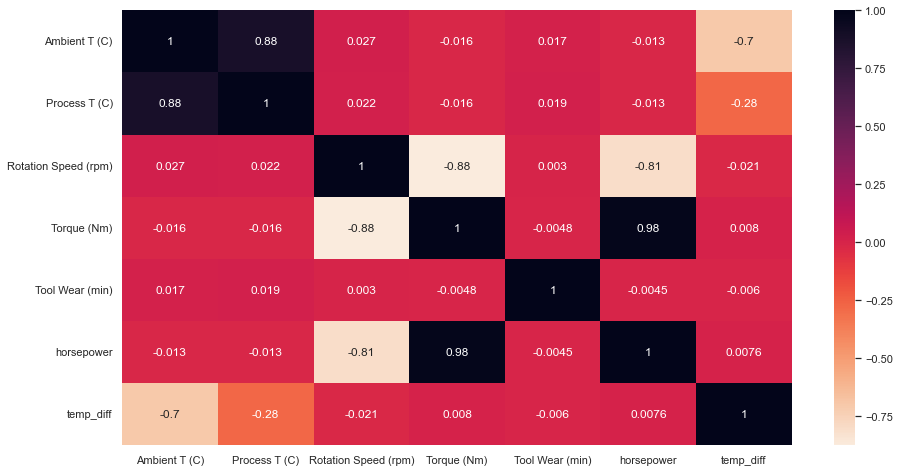

In [543]:
numerical_cols = X_train.loc[:, X_train.columns != 'quality'] # take only numerical column names

numerical_data = X_train[list(numerical_cols.columns)]

plt.figure(figsize=(15,8)) 
sns.heatmap(numerical_data.corr(), annot=True, cmap='rocket_r')

plt.show

In [544]:
def vif_calc(data): # calculate vif using statsmodels vif package
    vif = pd.DataFrame()
    vif["variables"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return(vif)

In [545]:
vif_calc(numerical_data)

,variables,VIF
0,Ambient T (C),8901.849914
1,Process T (C),4857.016607
2,Rotation Speed (rpm),5.768826
3,Torque (Nm),48.908599
4,Tool Wear (min),1.000490
5,horsepower,32.906189
6,temp_diff,2232.927975


In [546]:
# drop Ambient T (C)	
X_train = X_train.drop(['Ambient T (C)'], axis=1)
X_test = X_test.drop(['Ambient T (C)'], axis=1)

In [547]:
# vif after dropping Ambient T (C)	
vif_calc(X_train[['Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'horsepower', 'temp_diff']])

,variables,VIF
0,Process T (C),1.082975
1,Rotation Speed (rpm),5.768824
2,Torque (Nm),48.907313
3,Tool Wear (min),1.000399
4,horsepower,32.905765
5,temp_diff,1.083149


## 6) Oversampling
This dataset is heavily imbalanced as the observations between both target features are unequal. Thus, minority oversampling or majority undersampling can be done to balance out the target label so that there will be more training examples for the minority target for the model to train on.

SMOTE will be used to generate more observations for the minority target label

The test set will not be oversampled as it should be used to replicate real-world data that the model would be receiving

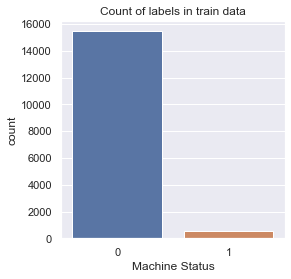

In [548]:
#countplot to compare the count of both machine status in the dataset
sns.set(rc={'figure.figsize':(4,4)})
ax = sns.countplot(x=y_train)
plt.title('Count of labels in train data')
plt.show()

In [549]:
oversample = SMOTE(random_state=42) # SMOTE object
X_train, y_train = oversample.fit_resample(X_train, y_train)

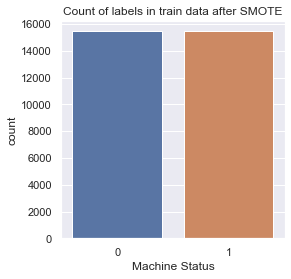

In [550]:
#countplot to compare the count of both machine status in the dataset
sns.set(rc={'figure.figsize':(4,4)})
ax = sns.countplot(x=y_train)
plt.title('Count of labels in train data after SMOTE')
plt.show()

## Final Check on dataset

In [551]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (30916, 7)
y_train shape: (30916,)

X_test shape: (4000, 7)
y_test shape: (4000,)


In [552]:
X_train.head()

,quality,Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower,temp_diff
0,0.0,0.301032,-0.633142,1.438379,-1.584608,1.710378,-1.098051
1,0.0,1.113269,0.660733,-0.869245,0.660617,-0.596865,0.695742
2,0.0,1.180955,-0.527178,1.118708,1.037438,1.360331,1.293673
3,0.0,-0.849637,3.670107,-2.697362,1.115943,-2.205678,-0.799085
4,1.0,0.639464,-0.159093,0.759078,-1.443300,1.159624,-2.094602


In [561]:
X_test.head()

,quality,Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),horsepower,temp_diff
0,2.0,0.977896,0.097451,-0.499625,0.880430,-0.539868,-1.197706
1,1.0,-0.781951,0.052835,-0.159975,-1.207787,-0.053596,-1.197706
2,1.0,-1.188069,-0.014089,-0.539584,-1.631711,-0.668130,0.795397
3,2.0,0.368718,1.408057,-1.198905,0.943233,-0.960642,1.492983
4,0.0,-0.511205,0.644002,-0.899214,1.461362,-0.850765,-0.799085


# ML Modelling

## Which metric to use?
As the dataset is imbalanced, the standard accuracy metric cannot be used as it would give us a inaccurate score of the model, which is not a good measure of how our model performs (Accuracy Paradox).

There are other score metrics when dealing with imbalanced datasets
1. Balanced Accuracy (Mean of recall of both true positives and true negatives)
2. f1-score (harmonic mean between precision and recall)

For this classification task, both of the above metrics will be used to evaluate the model.

In [554]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier

## Dummy Classifier
The dummy model gave a accuracy score of 0.5, which is fair for a baseline model as it makes predictions but ignoring input features.
This score will be used as a reference point for model selection

In [555]:
#Instantiate a DummyClassifier object
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(X_train, y_train)

dummy_clf.score(X_test, y_test)

0.49925

## Testing different Classification Models
I put all the models I want to try out into a dictionary, then test each of a model using 5-fold cross validation.

* From the results, it is shown that ensemble learning models generally perform better than classical models for this classification task.
* From the ensemble learning models, I decided to go ahead and use Random Forest Classifier as it has the highest balanced accuracy test score, which means that it dealt with the minority labels the best out of all the models
* Random Forest is also less prone to overfitting compared to other models as it is made up of many weak classifiers that are trained independently on different subsets of the training data.

In [501]:
# Testing different models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Histogram-based Gradient Boosting': HistGradientBoostingClassifier(random_state=42),
    'Extra Trees Classifier': ExtraTreesClassifier(random_state=42),
    'BaggingClassifier': BaggingClassifier(random_state=42)
}

ba_cv_scores = []
f1_cv_scores = []
auc_cv_scores = []

ba_test = []
f1_test = []
auc_test = []

for name in models:
  model = models[name]
  ba_cv_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')))
  f1_cv_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1')))
  auc_cv_scores.append(np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')))

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  ba_test.append(balanced_accuracy_score(y_test, y_pred))
  f1_test.append(f1_score(y_test, y_pred))
  auc_test.append(roc_auc_score(y_test, y_pred))

model_list = []
for index, (key, value) in enumerate(models.items()):
  model_list.append(key)

results = {'Model': model_list, 
           '5-fold cv (Balanced Accuracy)': ba_cv_scores, 
           'ba_test': ba_test,
           '5-fold cv (f1 Score)': f1_cv_scores, 
           'f1_test': f1_test,
           '5-fold cv (auc)': auc_cv_scores,
           'auc_test': auc_test
           }

results_df = pd.DataFrame(results)

In [502]:
results_df

,Model,5-fold cv (Balanced Accuracy),ba_test,5-fold cv (f1 Score),f1_test,5-fold cv (auc),auc_test
0,K-Nearest Neighbors,0.980981,0.935772,0.981317,0.637306,0.995684,0.935772
1,Decision Tree,0.987256,0.950706,0.987257,0.826667,0.987256,0.950706
2,Logistic Regression,0.849204,0.838159,0.847921,0.290237,0.929916,0.838159
3,Support Vector Machine,0.954490,0.920838,0.955464,0.516949,0.985558,0.920838
4,Random Forest,0.994857,0.968906,0.994857,0.924188,0.999740,0.968906
5,AdaBoost,0.934920,0.931350,0.935004,0.521921,0.982184,0.931350
6,Gradient Boosting,0.960344,0.932020,0.960663,0.592771,0.993567,0.932020
7,Histogram-based Gradient Boosting,0.991234,0.943095,0.991263,0.813333,0.999526,0.943095
8,Extra Trees Classifier,0.996313,0.954718,0.996318,0.921933,0.999942,0.954718
9,BaggingClassifier,0.991073,0.949100,0.991058,0.869258,0.998574,0.949100


## Model Selection: Random Forest Classifier
The Random Forest Classifier before tuning hyperparameters did really well classifying the imbalanced test set

Looking at the confusion matrix
* It predicted 13 majority labels wrongly out of 3851 labels
* It also predicted only 8 labels wrongly out of 128 minority labels, thus achieving a high balanced accuracy score of 0.9689 as balanced accuracy favors the minority labels more

In [503]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}')
print(f'f1 score: {f1_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred))

Balanced Accuracy: 0.9689060406771404
f1 score: 0.924187725631769

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3864
           1       0.91      0.94      0.92       136

    accuracy                           0.99      4000
   macro avg       0.95      0.97      0.96      4000
weighted avg       0.99      0.99      0.99      4000



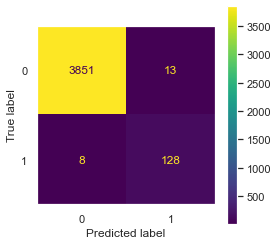

In [504]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

## Grid Search CV
GridSearchCV will be used to tune the hyperparameters of the Random Forest Classifier

The tuning will be focused on making the predictions stronger and more reliable, hence focusing on n_estimators


After applying the best parameters GridSearchCV recommended, the model's balanced accuracy decreased by 1% while f1 score increased by 1%, lets see why
* Minority labels classified wrongly went up by 3, from 8 to 11
* Majority labels classified wrongly went down by 6, from 13 to 7

Even though total number of wrong classifications went down by 3, balanced accuracy still went down as it punishes the model hard for classifying the minority labels wrongly.

In [505]:
# Hyperparemeters to tune using GridSearchCV
n_estimators = [650, 700, 750]
max_features = [None, 1, 2]


# Create the parameter grid
params = {'n_estimators': n_estimators,
          'max_features': max_features
}

In [565]:
# Random search of parameters, using 3 fold cross validation
grid_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, cv=5,
                          n_jobs=-1,scoring='f1')

grid_rfc.fit(X_train, y_train)

print(grid_rfc.best_params_)

{'criterion': 'entropy', 'max_features': 1, 'n_estimators': 700}


In [567]:
# using best hyperparameters from randomized search cv on the model
rfc_tuned = RandomForestClassifier(random_state=42, n_estimators=750, max_features=1)

rfc_tuned.fit(X_train, y_train)

y_pred = rfc_tuned.predict(X_test)

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred)}')

Balanced Accuracy: 0.9586530264279625
f1_score: 0.9328358208955223


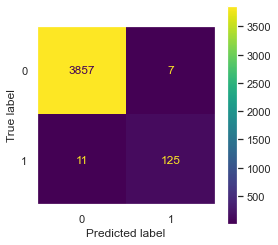

In [566]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

## Feature Importance
We can see that all 7 features that are left after preprocessing are used to decide whether a machine has failed or not. It can be concluded that with 7 of these values, we can effectively decide whether a machine has failed or not.

In [560]:
pd.DataFrame(list(zip(X_train.columns, rfc_tuned.feature_importances_)), columns = ['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
3,Torque (Nm),0.210710
2,Rotation Speed (rpm),0.195806
5,horsepower,0.190401
4,Tool Wear (min),0.167444
6,temp_diff,0.137654
1,Process T (C),0.066125
0,quality,0.031858
